In [21]:
import ReplayBuffer
import TD3
import gym 
import json

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.2.0
Found GPU at: /device:GPU:0


In [22]:
REF_EXPERIMENT = 'Test_200k'

In [23]:
ROOT = '.'
FOLDER_EXPORT_WEIGHTS = os.path.join(ROOT, REF_EXPERIMENT, 'weights')
FOLDER_EXPORT_RESULTS = os.path.join(ROOT, REF_EXPERIMENT, 'results')

os.makedirs(FOLDER_EXPORT_RESULTS)
os.makedirs(FOLDER_EXPORT_WEIGHTS)

In [24]:
ENV_NAME = 'HalfCheetah-v2'
RND_SEED = 20210122
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
BATCH_SIZE = 256
DISCOUNT = 0.99
TAU = 0.005
POLICY_FREQ = 2

START_TIMESTEPS = 25e3
MAX_TIMESTEPS = 200000

EXPLORATION_NOISE = 0.1

EVALUATION_FREQ = 5e3

In [25]:
def eval_policy(policy, env_name, seed, eval_episodes=10):
	eval_env = gym.make(env_name)
	eval_env.seed(seed + 100)

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.pi(np.array(state))
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward

In [26]:
#set random seed 
tf.random.set_seed(RND_SEED)
np.random.seed(RND_SEED)

env = gym.make(ENV_NAME)
env.seed(RND_SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_value_action = float(env.action_space.high[0])


kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_value_action": max_value_action,
    "discount": DISCOUNT,
    "tau": TAU,
    "policy_noise": POLICY_NOISE* max_value_action,
    "noise_clip": NOISE_CLIP * max_value_action,
    "policy_freq": POLICY_FREQ,
}

policy = TD3.TD3(**kwargs)
replay_buffer = ReplayBuffer.ReplayBuffer(state_dim, action_dim)

In [27]:
history = {}
history['timestamp'] = []
history['evaluation'] = []

In [28]:
#  Evaluate untrained policy
history['timestamp'].append(0)
history['evaluation'].append(eval_policy(policy, ENV_NAME, RND_SEED))

---------------------------------------
Evaluation over 10 episodes: -0.505
---------------------------------------


In [29]:
state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

In [30]:
#save best model:
max_avg_reward = -1e6

for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < START_TIMESTEPS:
        action = env.action_space.sample()  #chose random action
    else:
        action_policy = policy.pi(np.array(state))
        noise = np.random.normal(0,  max_value_action * EXPLORATION_NOISE , size=action_dim)
        action = action_policy + noise 
        action = tf.clip_by_value(action, clip_value_min=-max_value_action, clip_value_max=max_value_action)
      
    # Perform action
    next_state, reward, done, _ = env.step(action) 
    done_f = float(done) if episode_timesteps < env._max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_f)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= START_TIMESTEPS:
        policy.train(replay_buffer, BATCH_SIZE)
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 
    
    # Evaluation
    if (t + 1) % EVALUATION_FREQ == 0:
        avg_reward = eval_policy(policy, ENV_NAME, RND_SEED)
        history['timestamp'].append(t)
        history['evaluation'].append(avg_reward)
        if avg_reward > max_avg_reward:
            out_path = os.path.join(FOLDER_EXPORT_WEIGHTS, "AVG_REW="+str(avg_reward))
            os.makedirs(out_path)
            policy.save_weights_networks(out_path)
            max_avg_reward = avg_reward

#export history
history_out_filename = os.path.join(FOLDER_EXPORT_RESULTS, 'history.json')
f_out = open(history_out_filename, 'w')
json.dump(history, f_out)
f_out.close()

Total T: 1000 Episode Num: 1 Episode T: 1000 Reward: -200.096
Total T: 2000 Episode Num: 2 Episode T: 1000 Reward: -485.521
Total T: 3000 Episode Num: 3 Episode T: 1000 Reward: -302.209
Total T: 4000 Episode Num: 4 Episode T: 1000 Reward: -465.284
Total T: 5000 Episode Num: 5 Episode T: 1000 Reward: -95.314
---------------------------------------
Evaluation over 10 episodes: -0.505
---------------------------------------
Total T: 6000 Episode Num: 6 Episode T: 1000 Reward: -220.086
Total T: 7000 Episode Num: 7 Episode T: 1000 Reward: -198.947
Total T: 8000 Episode Num: 8 Episode T: 1000 Reward: -260.268
Total T: 9000 Episode Num: 9 Episode T: 1000 Reward: -290.012
Total T: 10000 Episode Num: 10 Episode T: 1000 Reward: -360.712
---------------------------------------
Evaluation over 10 episodes: -0.505
---------------------------------------
Total T: 11000 Episode Num: 11 Episode T: 1000 Reward: -266.711
Total T: 12000 Episode Num: 12 Episode T: 1000 Reward: -258.997
Total T: 13000 Epis

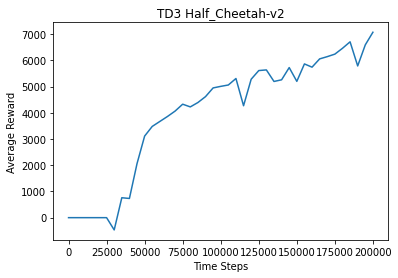

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history['timestamp'], history['evaluation'])
plt.title('TD3 Half_Cheetah-v2')
plt.ylabel('Average Reward')
plt.xlabel('Time Steps')
plt.savefig(os.path.join(FOLDER_EXPORT_RESULTS, "history.png"))